In [1]:
# import os
import itertools
import numpy as np
import sympy as sp

# import colorsys
import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors

from sklearn.linear_model import LinearRegression

import dimod
from dimod import BinaryQuadraticModel, ExactSolver
from dwave.system import DWaveSampler, EmbeddingComposite

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### i-QLS Algorithm


**Note:** If you want to run on a real quantum annealer, this requires you to have an account in [D-Wave Ocean](https://cloud.dwavesys.com/), up on logging in, the D-Wave Leap dashboard is displayed, you can find the private token on the left column under **Solver API Token**, and place it in a file named `dwave-api-token.txt` in the same directory as this notebook.


If you do not wish to run the problem on the remote quantum annealer, you can also try out the D-Wave's exact solver which runs locally on your machine which is the default implementation below but does not scale well for larger number of features.

In [2]:
def i_qls(number_of_features=2, bits_per_weight=2, number_of_iterations=1, initial_bound=1000, X=None, y_values=None):
    bit_count = number_of_features * bits_per_weight
    b = [sp.symbols(f'b{bit_idx}') for bit_idx in range(bit_count)]
    x = [sp.symbols(f'x{x_idx}') for x_idx in range(number_of_features)]

    upper_bound = 2 ** (bits_per_weight-1) - 2 ** -1
    upper_bound = initial_bound
    lower_bound = -upper_bound
    bin_sizes = [(upper_bound - lower_bound) / (2 ** bits_per_weight - 1) for _ in range(number_of_features)]
    w = [lower_bound + sum([bin_sizes[w_idx] * (2 ** (bits_per_weight - 1 - bit_idx)) * b[w_idx * bits_per_weight + bit_idx] 
                            for bit_idx in range(bits_per_weight)]) 
                            for w_idx in range(number_of_features)]

    # Initialize variables
    iteration_count = 0
    mse_list = []  # To store MSE for each iteration
    weights_dict = {}
    lower_bounds_dict = {}
    upper_bounds_dict = {}
    mse = np.mean([(y_val - sum([0 * x[w_idx] for w_idx in range(number_of_features)])) ** 2 for x, y_val in zip(X, y_values)])
    mse_list.append(mse)
    print(f"Iteration {iteration_count} - MSE: {mse}")
    lower_bounds_list = []
    upper_bounds_list = []
    weights_list = []
    for w_idx,weight in enumerate(w):
        weights_list.append(0)
        lower_bounds_list.append(lower_bound)
        upper_bounds_list.append(upper_bound)
    weights_dict[iteration_count] = weights_list
    lower_bounds_dict[iteration_count] = lower_bounds_list
    upper_bounds_dict[iteration_count] = upper_bounds_list
    reduction_factor = 2
    if bits_per_weight == 1:
        reduction_factor = 4

    while iteration_count < number_of_iterations:
        # Update weights in each iteration
        if iteration_count:
            w = []
            lower_bounds_list = []
            upper_bounds_list = []
            weights_list = []
            for w_idx, opt_weight in enumerate(optimal_weights):
                # Update bounds in each iteration
                upper_bound = opt_weight + (bin_sizes[w_idx] / reduction_factor)
                lower_bound = opt_weight - (bin_sizes[w_idx] / reduction_factor)
                weights_list.append(opt_weight)
                lower_bounds_list.append(lower_bound)
                upper_bounds_list.append(upper_bound)
                bin_sizes[w_idx] = (upper_bound - lower_bound) / (2 ** bits_per_weight - 1)
                w.append(lower_bound + sum([bin_sizes[w_idx] * (2 ** (bits_per_weight - 1 - bit_idx)) * b[w_idx * bits_per_weight + bit_idx] for bit_idx in range(bits_per_weight)]))
            weights_dict[iteration_count] = weights_list
            lower_bounds_dict[iteration_count] = lower_bounds_list
            upper_bounds_dict[iteration_count] = upper_bounds_list

        # Calculate the total loss (MSE)
        total_loss = sum([(y_val - sum([w[w_idx] * x[w_idx] for w_idx in range(number_of_features)])) ** 2 for i, (x, y_val) in enumerate(zip(X, y_values))])
        total_loss_expanded = sp.expand(total_loss)
        simplified_loss = total_loss_expanded.subs({b[bit_idx] ** 2: b[bit_idx] for bit_idx in range(bit_count)})

        # Collect QUBO terms
        qubo_terms = sp.collect(simplified_loss, b + [b_i * b_j for b_i, b_j in itertools.combinations(b, 2)], evaluate=False)

        quadratic = {}
        linear = {}
        for term, coeff in qubo_terms.items():
            if isinstance(term, sp.Symbol):  # Linear terms (b0, b1, ...)
                idx = b.index(term)
                linear[idx] = coeff
            elif isinstance(term, sp.Mul):  # Interaction terms (b0*b1, ...)
                vars_in_term = list(term.args)
                idx1 = b.index(vars_in_term[0])
                idx2 = b.index(vars_in_term[1])
                quadratic[(idx1, idx2)] = coeff

        #############################################################################################################
        # SELECT THE QUBO SOLVER
        #############################################################################################################
        # This is to run locally on your system using an Exact QUBO solver
        sampler = ExactSolver()
        #############################################################################################################
        # Comment the above line, and uncomment the below three lines for running on a remote quantum annealer hardware
        # private_token = open('dwave-api-token.txt','r').read()
        # dwave_sampler = DWaveSampler(token = private_token)
        # sampler = EmbeddingComposite(dwave_sampler)
        #############################################################################################################
        
        # Solve the QUBO problem
        bqm = BinaryQuadraticModel(linear, quadratic, 0.0, dimod.BINARY)
        response = sampler.sample(bqm)
        # Get optimal solution and update weights
        optimal_solution = list(map(int, response.first.sample.values()))
        optimal_weights = [w[w_idx].subs({b[bit_idx]: optimal_solution[bit_idx] for bit_idx in range(bit_count)}) for w_idx in range(number_of_features)]

        # Calculate MSE at this iteration and store it
        mse = np.mean([(y_val - sum([optimal_weights[w_idx] * x[w_idx] for w_idx in range(number_of_features)])) ** 2 for x, y_val in zip(X, y_values)])
        mse_list.append(mse)

        iteration_count += 1
        print(f"Iteration {iteration_count} - MSE: {mse}")

        if mse==0:
            lower_bounds_list = []
            upper_bounds_list = []
            weights_list = []
            for w_idx, opt_weight in enumerate(optimal_weights):
                upper_bound = opt_weight
                lower_bound = opt_weight
                weights_list.append(opt_weight)
                lower_bounds_list.append(lower_bound)
                upper_bounds_list.append(upper_bound)
            weights_dict[iteration_count] = weights_list
            lower_bounds_dict[iteration_count] = lower_bounds_list
            upper_bounds_dict[iteration_count] = upper_bounds_list
            break

    return mse_list, optimal_weights, weights_dict, lower_bounds_dict, upper_bounds_dict


In [3]:
import numpy as np

def linear_spline_basis(X, knots):
    """
    Piece-wise-linear spline **without** per-segment intercepts.
    The design matrix contains
        • one global intercept column  (all 1’s),
        • one global linear column     (x itself),
        • one “hinge”  (x − κ_j)_+     for every *interior* knot κ_j.

    This is the classical truncated–power basis for a C¹ continuous
    linear spline and is full-rank without further constraints.

    Parameters
    ----------
    X : (N,) array_like
        Input points.
    knots : (M,) array_like  (strictly increasing)
        Knot locations κ₀ < κ₁ < … < κ_{M−1}.
        The first and last knots define the outer domain; only the
        interior knots κ₁,…,κ_{M−2} generate hinge columns.

    Returns
    -------
    B : ndarray, shape = (N, 2 + M − 2)
        Design matrix  [ 1 ,  x ,  (x−κ₁)_+ , … , (x−κ_{M−2})_+ ].
    """
    X = np.asarray(X).ravel()
    knots = np.asarray(knots).ravel()
    if np.any(np.diff(knots) <= 0):
        raise ValueError("knots must be strictly increasing")

    # --- global intercept and slope ---
    cols = [np.ones_like(X), X.copy()]

    # --- hinge functions for each interior knot ---
    for k in knots[1:-1]:                    # skip first & last knots
        cols.append(np.maximum(0.0, X - k))

    return np.column_stack(cols)


### Generate Sine Data

In [7]:
def generate_sin_data(num_samples=100, noise_std=0.05, random_seed=42):
    """
    Generate synthetic data from y = sin(x) in the range [-1, 1] with optional noise.
    
    Parameters:
        num_samples (int): Number of points to generate.
        noise_std (float): Standard deviation of Gaussian noise.
        random_seed (int): Seed for reproducibility.
    
    Returns:
        X (numpy array): Input x values.
        y (numpy array): Corresponding y values with noise.
    """
    np.random.seed(random_seed)
    X = np.linspace(-1, 1, num_samples).reshape(-1, 1)  # Generate x values
    y = np.sin(np.pi * X).flatten()  # True y values
    noise = np.random.normal(0, noise_std, size=y.shape)  # Gaussian noise
    y_noisy = y + noise  # Add noise to simulate real-world data
    return X, y_noisy


# Generate synthetic sin(x) data
X, y = generate_sin_data(num_samples=100, noise_std=0.00)

Iteration 0 - MSE: 0.49499999999999994
Iteration 1 - MSE: 0.0158691912859332
Iteration 2 - MSE: 0.00655848096584337
Iteration 3 - MSE: 0.00549708079951122
Iteration 4 - MSE: 0.00538687284252836
Iteration 5 - MSE: 0.00537252677698179


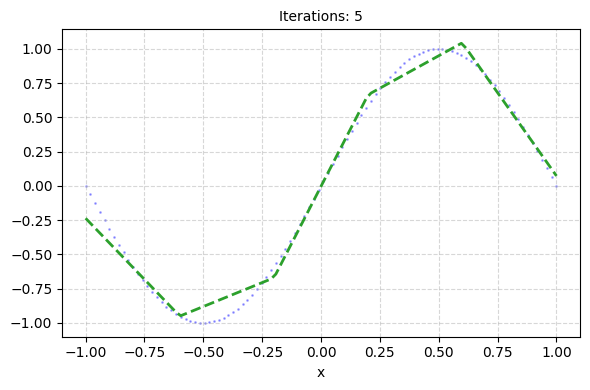

In [ ]:
# Define number of knots and iteration list
num_knots = 6
n_iterations_list = [5]

# Create a single-row figure with subplots for each iteration count
fig, ax = plt.subplots(1, len(n_iterations_list), figsize=(6, 4))#, sharey=True)

# for ax, n_iterations in zip(axes, n_iterations_list):
knots = np.linspace(-1, 1, num_knots)

# Generate spline basis features
B = linear_spline_basis(X, knots)
B_augmented = np.hstack([np.ones((B.shape[0], 1)), B])

# Linear Regression with Quantum Annealer
mse_list, optimal_weights, weights_dict, lower_bounds_dict, upper_bounds_dict = i_qls(
    number_of_features=B_augmented.shape[1],
    bits_per_weight=3,
    number_of_iterations=n_iterations_list[0],  # Varying iterations
    initial_bound=3,
    X=B_augmented,
    y_values=y
)

y_pred_QA = np.matmul(B_augmented, optimal_weights).T

# Plot on the corresponding subplot
ax.scatter(X, y, color='blue', alpha=0.3, s=1)
# ax.plot(X, y_pred, color='tab:red', linestyle='-', linewidth=2.0, label="Scikit-Learn")
ax.plot(X, y_pred_QA.tolist(), color='tab:green', linestyle='--', linewidth=2.0, label="Quantum Annealer")
ax.set_xlabel("x", fontsize=10)
ax.set_title(f"Iterations: {n_iterations_list[0]}", fontsize=10)
ax.grid(True, linestyle="--", alpha=0.5)


# Adjust layout for a clean display
plt.tight_layout()

# Save and display
# plt.savefig("nonlinear_figures/spline_iterations_comparison_sigmoid.png", dpi=300, bbox_inches='tight', transparent=False)
plt.show()

## Generate Sigmoid Data

In [28]:
def generate_sigmoid_data(num_samples=100, noise_std=0.05, random_seed=42):
    """
    Generate synthetic data from y = sigmoid(πx) in the range [-1, 1] with optional noise.
    
    Parameters:
        num_samples (int): Number of points to generate.
        noise_std (float): Standard deviation of Gaussian noise.
        random_seed (int): Seed for reproducibility.
    
    Returns:
        X (numpy array): Input x values.
        y (numpy array): Corresponding y values with noise.
    """
    np.random.seed(random_seed)
    X = np.linspace(-1, 1, num_samples).reshape(-1, 1)  # Generate x values
    y = 1 / (1 + np.exp(-np.pi * X)).flatten()  # True y values
    noise = np.random.normal(0, noise_std, size=y.shape)  # Gaussian noise
    y_noisy = y + noise  # Add noise to simulate real-world data
    return X, y_noisy

# Generate synthetic sin(x) data
X, y = generate_sigmoid_data(num_samples=100, noise_std=0.00)

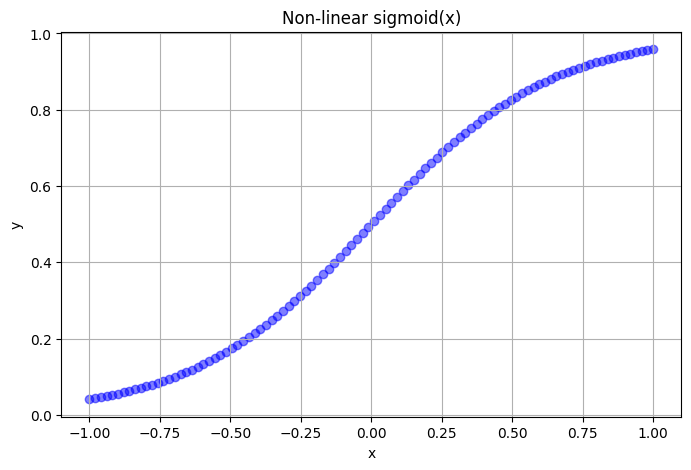

In [29]:
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', label="Noisy Data", alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Non-linear sigmoid(x)")
plt.grid(True)
plt.show()

Iteration 0 - MSE: 0.3550971385961948
Iteration 1 - MSE: 0.00130710419167268
Iteration 2 - MSE: 0.000541176383850317
Iteration 3 - MSE: 0.000450822788627321
Iteration 4 - MSE: 0.000441056732033946
Iteration 5 - MSE: 0.000439610045581683


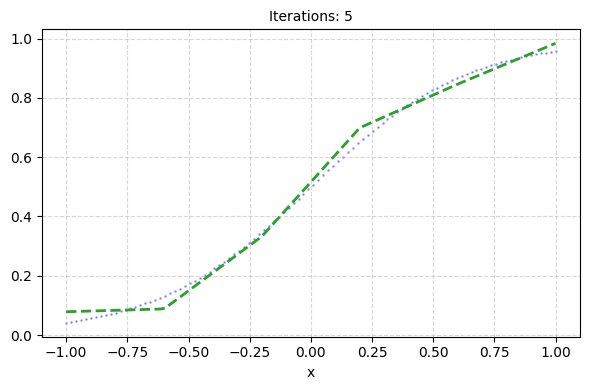

In [ ]:
# Define number of knots and iteration list
num_knots = 6
n_iterations_list = [5]

# Create a single-row figure with subplots for each iteration count
fig, ax = plt.subplots(1, len(n_iterations_list), figsize=(6, 4))#, sharey=True)

# for ax, n_iterations in zip(axes, n_iterations_list):
knots = np.linspace(-1, 1, num_knots)

# Generate spline basis features
B = linear_spline_basis(X, knots)
B_augmented = np.hstack([np.ones((B.shape[0], 1)), B])

# Linear Regression with Quantum Annealer
mse_list, optimal_weights, weights_dict, lower_bounds_dict, upper_bounds_dict = i_qls(
    number_of_features=B_augmented.shape[1],
    bits_per_weight=3,
    number_of_iterations=n_iterations_list[0],  # Varying iterations
    initial_bound=1,
    X=B_augmented,
    y_values=y,
)

y_pred_QA = np.matmul(B_augmented, optimal_weights).T

# Plot on the corresponding subplot
ax.scatter(X, y, color='blue', alpha=0.3, s=1)
ax.plot(X, y_pred_QA.tolist(), color='tab:green', linestyle='--', linewidth=2.0, label="Quantum Annealer")
ax.set_xlabel("x", fontsize=10)
ax.set_title(f"Iterations: {n_iterations_list[0]}", fontsize=10)
ax.grid(True, linestyle="--", alpha=0.5)

# Adjust layout for a clean display
plt.tight_layout()

# Save and display
# plt.savefig("nonlinear_figures/spline_iterations_comparison_sigmoid.png", dpi=300, bbox_inches='tight', transparent=False)
plt.show()